<a href="https://colab.research.google.com/github/julotec/accelermometer_readings/blob/main/tensorflow_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tworzenie sieci neuronowej

W tym zadaniu stworzymy w pełni połączoną sieć neuronową przy użyciu niskopoziomowych mechanizmów tensorflow.

Architektura sieci neuronowej została przedstawiona na poniższym rysunku. Jak widać, ma ona jedną warstwę wejściową, dwie warstwy ukryte i warstwę wyjściową. W warstwach ukrytych wykorzystamy sigmoid jako funkcję aktywacji. Na warstwie wyjściowej użyjemy softmax.

Część kodu do utworzenia sieci została już napisana, musisz wypełnić puste miejsca w określonych miejscach.

## Architektura sieci neuronowej

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Informacje o zestawie danych MNIST

Będziemy trenować tę sieć neuronową na zbiorze danych MNIST. Ten zbiór danych to duża liczba odręcznych obrazów cyfr składających się z 28 razy 28 pikseli. Każdy piksel przyjmuje wartość od 0 do 255.

Tak jak poprzednio, zbiór danych zostanie podzielony na próbki treningowe i testowe. Znormalizujemy wszystkie obrazy tak, aby wartości pikseli wynosiły od 0 do 1, dzieląc jasność każdego piksela przez 255.

Ponadto architektura sieci neuronowej oczekuje wektora jako danych wejściowych. W naszym przypadku jednak każdy przykładowy obiekt jest macierzą. Co należy zrobić? W tym zadaniu "rozciągniemy" macierz 28 razy 28$, uzyskując w ten sposób wektor składający się z 784 elementów.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Więcej informacji na temat zbioru danych można znaleźć na stronie [tutaj](http://yann.lecun.com/exdb/mnist/).

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 3000 # maksymalna liczba epok
batch_size = 256 # przeliczymy wagi sieci nie na całej próbce, ale na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 128 # liczba neuronów warstwy 1
n_hidden_2 = 256 # liczba neuronów warstwy 2

In [4]:
from tensorflow.keras.datasets import mnist

# Ładowanie zestawu danych
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwertujemy macierze 28x28 pikseli na wektor składający się z 784 elementów
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Zmiksujmy dane treningowe
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
# Stwórzmy sieć neuronową

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        # Inicjalizacja wag i biasów
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name='w')
        self.b = tf.Variable(tf.zeros([out_features]), name='b')

    def __call__(self, x):
        # Operacja warstwy liniowej
        z = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(z)  # funkcja aktywacji ReLU

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Pierwsza warstwa, składająca się ze 128 neuronów
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        # Druga warstwa, składająca się z 256 neuronów
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        # Warstwa wyjściowa
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        # Przepuszczanie danych przez kolejne warstwy sieci
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out_layer(x)
        # Stosujemy funkcję softmax na wyjściu
        return tf.nn.softmax(x)

In [6]:
# W tym przypadku wygodnie jest przyjąć entropię krzyżową jako funkcję błędu
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Obliczanie entropii krzyżowej
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Jako miernik jakości stosujemy dokładność
def accuracy(y_pred, y_true):
    # Porównywanie przewidzianych etykiet z prawdziwymi
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Obliczanie dokładności
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [7]:
# Stwórzmy przykładową sieć neuronową
neural_net = NN(name="mnist")

# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
    # Do dopasowania wag sieci wykorzystamy stochastyczne zejście gradientowe
    optimizer = tf.optimizers.SGD(learning_rate)

    # Aktywacja automatycznego różnicowania
    with tf.GradientTape() as g:
        pred = nn(input_x)
        loss = cross_entropy(pred, output_y)

        # Utwórz zoptymalizowaną listę parametrów
        trainable_variables = nn.trainable_variables

        # Oblicz na ich podstawie wartość gradientu
        gradients = g.gradient(loss, trainable_variables)

        # Zmodyfikuj parametry
        optimizer.apply_gradients(zip(gradients, trainable_variables))

# Trenowanie modelu
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print(f"step: {step}, loss: {loss:.4f}, accuracy: {acc:.4f}")

# Testowanie modelu
pred = neural_net(x_test)
print(f"Test Accuracy: {accuracy(pred, y_test):.4f}")

step: 100, loss: 18.6186, accuracy: 0.1016
step: 200, loss: 19.4339, accuracy: 0.0586
step: 300, loss: 18.5383, accuracy: 0.1055
step: 400, loss: 18.9424, accuracy: 0.0859
step: 500, loss: 18.5379, accuracy: 0.1055
step: 600, loss: 19.1852, accuracy: 0.0742
step: 700, loss: 18.0519, accuracy: 0.1289
step: 800, loss: 18.3886, accuracy: 0.1094
step: 900, loss: 17.6999, accuracy: 0.1406
step: 1000, loss: 18.0536, accuracy: 0.1289
step: 1100, loss: 17.8184, accuracy: 0.1367
step: 1200, loss: 16.9204, accuracy: 0.1836
step: 1300, loss: 16.8762, accuracy: 0.1836
step: 1400, loss: 16.5948, accuracy: 0.1992
step: 1500, loss: 15.9472, accuracy: 0.2305
step: 1600, loss: 15.9473, accuracy: 0.2305
step: 1700, loss: 15.9472, accuracy: 0.2305
step: 1800, loss: 17.1233, accuracy: 0.1719
step: 1900, loss: 16.0554, accuracy: 0.2227
step: 2000, loss: 15.2186, accuracy: 0.2656
step: 2100, loss: 16.7376, accuracy: 0.1914
step: 2200, loss: 15.8860, accuracy: 0.2305
step: 2300, loss: 15.5901, accuracy: 0.24

In [8]:
# Szkolenie sieciowe
loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście

# W tej pętli będziemy trenować sieć neuronową
# Z treningowego zbioru danych train_data, wyodrębnij losowy podzbiór, na którym
# będzie trenowana. Użyj metody take dostępnej dla szkoleniowego zbioru danych.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Aktualizacja wag sieci neuronowej
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        # Oblicz stratę i dokładność
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)

        # Zapisz stratę i dokładność w historii
        loss_history.append(loss)
        accuracy_history.append(acc)

        # Wyświetl bieżące statystyki
        print(f"step: {step}, loss: {loss:.4f}, accuracy: {acc:.4f}")

step: 100, loss: 14.7338, accuracy: 0.2891
step: 200, loss: 14.9546, accuracy: 0.2773
step: 300, loss: 14.3282, accuracy: 0.3086
step: 400, loss: 14.4929, accuracy: 0.2969
step: 500, loss: 14.1689, accuracy: 0.3164
step: 600, loss: 13.4378, accuracy: 0.3516
step: 700, loss: 14.9977, accuracy: 0.2734
step: 800, loss: 14.7331, accuracy: 0.2891
step: 900, loss: 14.3284, accuracy: 0.3086
step: 1000, loss: 13.4471, accuracy: 0.3477
step: 1100, loss: 14.3416, accuracy: 0.3047
step: 1200, loss: 13.7860, accuracy: 0.3320
step: 1300, loss: 14.0853, accuracy: 0.3203
step: 1400, loss: 13.7615, accuracy: 0.3359
step: 1500, loss: 14.0853, accuracy: 0.3203
step: 1600, loss: 14.0853, accuracy: 0.3203
step: 1700, loss: 14.3282, accuracy: 0.3086
step: 1800, loss: 13.7704, accuracy: 0.3320
step: 1900, loss: 12.8755, accuracy: 0.3750
step: 2000, loss: 14.8139, accuracy: 0.2852
step: 2100, loss: 13.5541, accuracy: 0.3359
step: 2200, loss: 13.5187, accuracy: 0.3477
step: 2300, loss: 14.5433, accuracy: 0.29

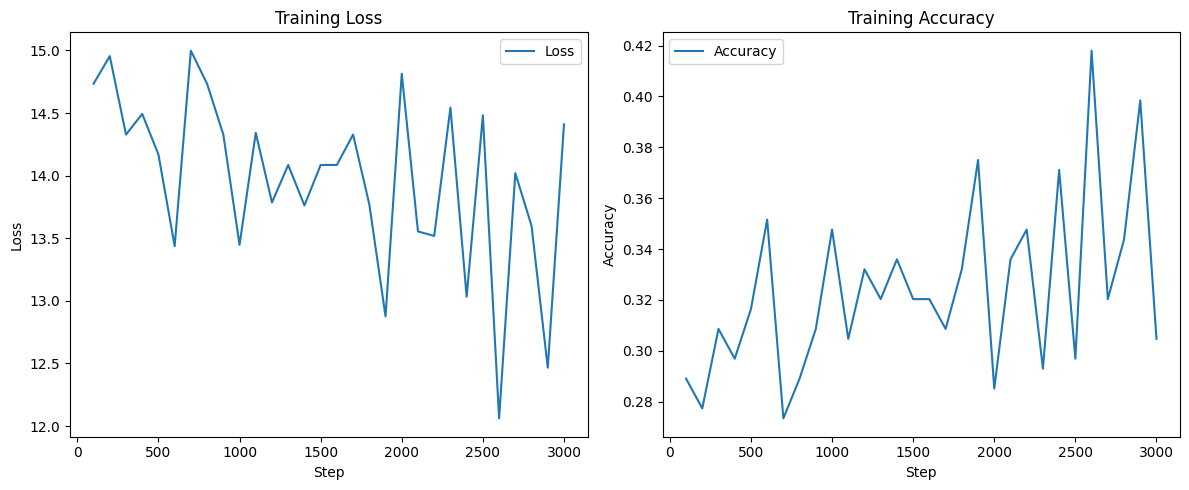

In [12]:
# Wykreślenie zmian dokładności i strat jako funkcji skoku
import matplotlib.pyplot as plt

# Funkcja wykreślająca wykresy strat i dokładności
def plot_metrics(loss_history, accuracy_history, display_step):
    steps = range(display_step, display_step * len(loss_history) + 1, display_step)

    plt.figure(figsize=(12, 5))

    # Wykres strat
    plt.subplot(1, 2, 1)
    plt.plot(steps, loss_history, label='Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Wykres dokładności
    plt.subplot(1, 2, 2)
    plt.plot(steps, accuracy_history, label='Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Wywołanie funkcji wykreślającej wykresy
plot_metrics(loss_history, accuracy_history, display_step)


In [13]:
# Obliczanie dokładności wytrenowanej sieci neuronowej

# Przewidywania na zbiorze testowym
pred_test = neural_net(x_test)

# Obliczanie dokładności na zbiorze testowym
test_accuracy = accuracy(pred_test, y_test)

# Wyświetlanie wyniku
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.3632


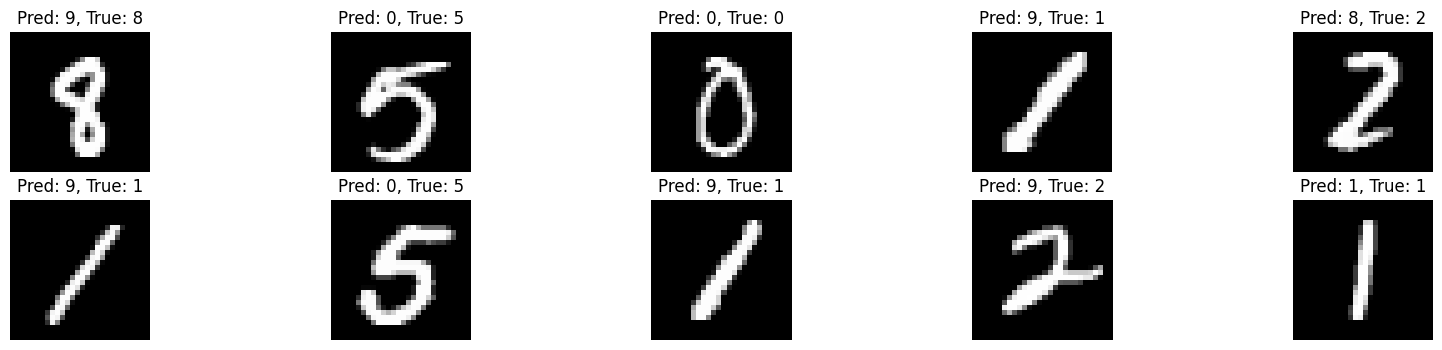

In [14]:
import random

# Funkcja do testowania wytrenowanej sieci na losowych obrazach
def test_random_images(nn, x_test, y_test, num_images=10):
    indices = random.sample(range(x_test.shape[0]), num_images)
    selected_images = x_test[indices]
    true_labels = y_test[indices]
    predictions = nn(selected_images)

    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(indices):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[idx].reshape(28, 28), cmap="gray")
        pred_label = np.argmax(predictions[i])
        true_label = y_test[idx]
        plt.title(f"Pred: {pred_label}, True: {true_label}")
        plt.axis("off")
    plt.show()

# Testowanie sieci na losowych obrazach
test_random_images(neural_net, x_test, y_test, num_images=10)
